# Random Forest para clustering jerárquico

Como se explicó en la clase, el algoritmo desarrollado por Leo Breiman permite su utilización para clustering; utilzando la distancia generada por la recurrencia de los casos en las hojas de cada uno de los árboles el ensamble.

Aquí se dará un pequeño tutorial utilizando la librería randomForest() de R.

## 1  Seteo del ambiente en Google Colab

Esta parte se debe correr con el runtime en Python3
<br>Ir al menu, Runtime -> Change Runtime Type -> Runtime type ->  **Python 3**

Conectar la virtual machine donde esta corriendo Google Colab con el  Google Drive, para poder tener persistencia de archivos

In [1]:
# primero establecer el Runtime de Python 3
from google.colab import drive
drive.mount('/content/.drive')

Drive already mounted at /content/.drive; to attempt to forcibly remount, call drive.mount("/content/.drive", force_remount=True).


<br>los siguientes comando estan en shell script de Linux
*   Crear las carpetas en el Google Drive
*   Bajar el  **competencia_01_crudo**  al  Google Drive  y tambien al disco local de la virtual machine que esta corriendo Google Colab

In [2]:
%%shell

mkdir -p "/content/.drive/My Drive/dmeyf"
mkdir -p "/content/buckets"
ln -s "/content/.drive/My Drive/dmeyf" /content/buckets/b1


mkdir -p /content/buckets/b1/exp
mkdir -p /content/buckets/b1/datasets
mkdir -p /content/datasets



archivo_origen="https://storage.googleapis.com/open-courses/dmeyf2025-e4a2/competencia_01_crudo.csv"
archivo_destino="/content/datasets/competencia_01_crudo.csv"
archivo_destino_bucket="/content/buckets/b1/datasets/competencia_01_crudo.csv"

if ! test -f $archivo_destino_bucket; then
  wget  $archivo_origen  -O $archivo_destino_bucket
fi


if ! test -f $archivo_destino; then
  cp  $archivo_destino_bucket  $archivo_destino
fi


ln: failed to create symbolic link '/content/buckets/b1/dmeyf': File exists


## 2. Generacion de la clase_ternaria

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

In [1]:
require( "data.table" )

# leo el dataset
dataset <- fread("/content/datasets/competencia_01_crudo.csv" )

# calculo el periodo0 consecutivo
dsimple <- dataset[, list(
    "pos" = .I,
    numero_de_cliente,
    periodo0 = as.integer(foto_mes/100)*12 +  foto_mes%%100 ) ]


# ordeno
setorder( dsimple, numero_de_cliente, periodo0 )

# calculo topes
periodo_ultimo <- dsimple[, max(periodo0) ]
periodo_anteultimo <- periodo_ultimo - 1


# calculo los leads de orden 1 y 2
dsimple[, c("periodo1", "periodo2") :=
    shift(periodo0, n=1:2, fill=NA, type="lead"),  numero_de_cliente ]

# assign most common class values = "CONTINUA"
dsimple[ periodo0 < periodo_anteultimo, clase_ternaria := "CONTINUA" ]

# calculo BAJA+1
dsimple[ periodo0 < periodo_ultimo &
    ( is.na(periodo1) | periodo0 + 1 < periodo1 ),
    clase_ternaria := "BAJA+1" ]

# calculo BAJA+2
dsimple[ periodo0 < periodo_anteultimo & (periodo0+1 == periodo1 )
    & ( is.na(periodo2) | periodo0 + 2 < periodo2 ),
    clase_ternaria := "BAJA+2" ]


# pego el resultado en el dataset original y grabo
setorder( dsimple, pos )
dataset[, clase_ternaria := dsimple$clase_ternaria ]

fwrite( dataset,
    file =  "/content/datasets/competencia_01.csv.gz",
    sep = ","
)

Loading required package: data.table



In [2]:
setorder( dataset, foto_mes, clase_ternaria, numero_de_cliente)
dataset[, .N, list(foto_mes, clase_ternaria)]

foto_mes,clase_ternaria,N
<int>,<chr>,<int>
202101,BAJA+1,622
202101,BAJA+2,825
202101,CONTINUA,160080
202102,BAJA+1,831
202102,BAJA+2,1032
202102,CONTINUA,160292
202103,BAJA+1,1039
202103,BAJA+2,951
202103,CONTINUA,161119


## 3. Modelo Random Forest

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Type -> Runtime type -> R

limpio el ambiente de R

In [3]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,724523,38.7,1454405,77.7,1454405,77.7
Vcells,1419196,10.9,169515700,1293.4,211569543,1614.2


In [4]:
# cargo las librerias que necesito
require("data.table")
if(!require("randomForest")) install.packages("randomForest")
require("randomForest")

if(!require('R.utils')) install.packages('R.utils')
require('R.utils')

Loading required package: randomForest

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.

Loading required package: R.utils

Loading required package: R.oo

Loading required package: R.methodsS3

R.methodsS3 v1.8.2 (2022-06-13 22:00:14 UTC) successfully loaded. See ?R.methodsS3 for help.

R.oo v1.27.1 (2025-05-02 21:00:05 UTC) successfully loaded. See ?R.oo for help.


Attaching package: ‘R.oo’


The following object is masked from ‘package:R.methodsS3’:

    throw


The following objects are masked from ‘package:methods’:

    getClasses, getMethods


The following objects are masked from ‘package:base’:

    attach, detach, load, save


R.utils v2.13.0 (2025-02-24 21:20:02 UTC) successfully loaded. See ?R.utils for help.


Attaching package: ‘R.utils’


The following object is masked from ‘package:utils’:

    timestamp


The following objects are masked from ‘package:base’:

    cat, commandArgs, getOption, isOpen, nullfile, parse, use, warnings




In [5]:
PARAM <- list()
PARAM$experimento <- 4329
PARAM$semilla_primigenia <- 290497 # Aquí poner su primer semilla

In [6]:
# carpeta de trabajo
setwd("/content/buckets/b1/exp")
experimento_folder <- paste0("CL", PARAM$experimento)
dir.create(experimento_folder, showWarnings=FALSE)
setwd( paste0("/content/buckets/b1/exp/", experimento_folder ))

In [7]:
# lectura del dataset
dataset <- fread("/content/datasets/competencia_01.csv.gz", stringsAsFactors= TRUE)

In [8]:
# los campos que se van a utilizar
campos_buenos <- copy(setdiff(colnames(dataset), c("clase_ternaria", "clase01")))

Nos vamos a quedar con los clientes que se dieron de baja para poder clusterizarlos.

In [9]:
#me quedo con los registros que no son CONTINUA
dataset_baja <- dataset[dataset$clase_ternaria=='BAJA+2']

La librería randomForest no procesa nativamente los datos faltantes para su entrenamiento, por lo que utilizaremos la función na.roughfix() para imputar los datos faltantes.

OPCIONALMENTE se puede recurrir a utilizar lightgbm en su modo Random Forest, con la ventaja de que lightgbm procesa nativamente los datos faltantes. Sin embargo, para poder utilizar el algoritmo en su modo no supervisado, se debe crear una variable objetivo ficticia, a la manera en la que lo desarrolló [Leo Breiman](https://www.stat.berkeley.edu/~breiman/forests/cc_home.htm) en su artículo.

In [10]:
# la libreria randomForest no procesa nativamente los datos faltantes para su entrenamiento
dataset_baja  <-  na.roughfix(dataset_baja)

Ejecutamos el modelo.
* Noten que la variable Y no es ingresada.
* La cantidad de árboles no es un parámetro fijo. Los instamos a experimentar con él.
* proximity si queda como hiperparámetro fijo ya que nos permite extraer la matriz de proximidades.
* oob.prox=TRUE construye la matriz con árboles "out of the bag", es decir que no utilizaron esos casos para entrenar el árbol.

In [11]:
set.seed(PARAM$semilla_primigenia)
# entrenamiento del modelo
modelo <- randomForest(dataset_baja[,..campos_buenos], y=NULL, ntree = 1000, proximity=TRUE, oob.prox = TRUE)

# obtenemos la matriz de proximidades
proximidades <- modelo$proximity

# la convertimos en un amatriz de distancias
distancias <- as.dist(1 - proximidades)

# Realizar clustering utilizando las proximidades
hclust_result <- hclust(distancias,method = "ward.D2")

# ahora podemos generar diversas cantidades de clústers y compararlos
for (k in 3:10){ # modificarlo a gusto, dependiendo de cuántos clústers prefieren obtener
  clusters <- cutree(hclust_result, k = k)
  dataset_baja[,paste0("labels_",k):= clusters]
}

In [12]:
# guardo algunos ejemplos en un .csv
fwrite(dataset_baja[,list(numero_de_cliente,labels_3,labels_4,labels_5)],'clusters.csv')

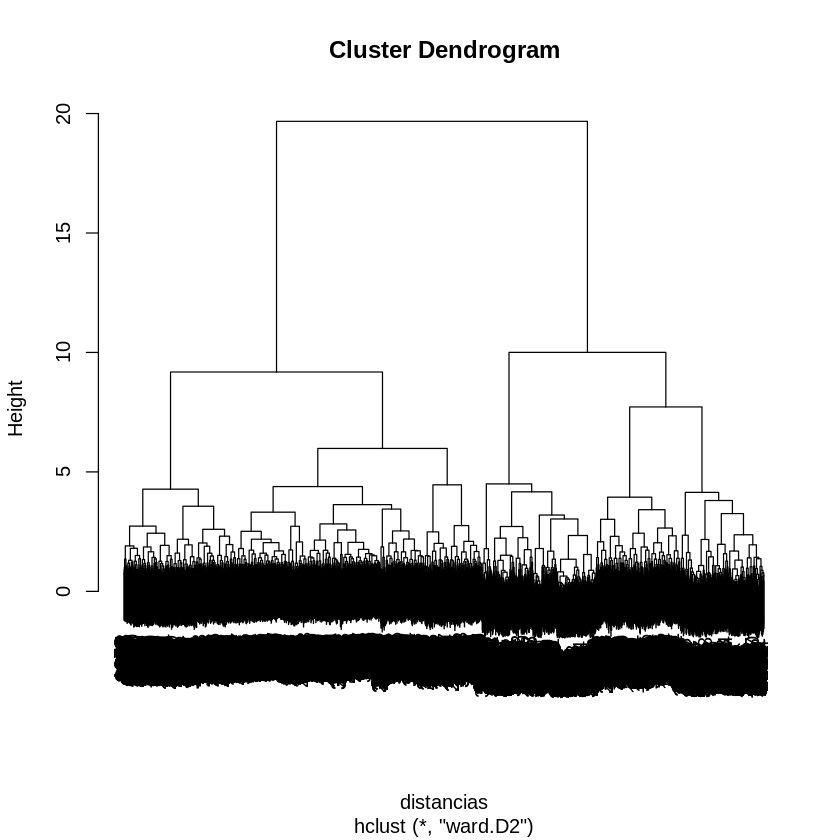

In [13]:
# incluso pueden visualizar el dendograma entero
plot(hclust_result)

Por último, queda utilizar el dataset histórico para evaluar cómo evolucionó cada clúster a lo largo del tiempo y seleccionar las variables más relevantes a la hora de definir cada clúster.

In [14]:
# me quedo con la historia de los clientes que se dieron de baja
dataset_historico <- dataset[dataset$numero_de_cliente %in% unique(dataset_baja$numero_de_cliente)]

# calculo el mes en que el cliente se dio de baja
dataset_baja[,mes_baja:=foto_mes+2]

Para eso combinamos el dataset con los clusters (nos quedamos con uno, en este caso el de 3 clusters) con el dataset histórico (conteniendo la historia de los clientes baja+2).

In [15]:
# combino el dataset_baja con el dataset_historico (solo me quedo con el numero de cliente y el cluster)
dataset_historico <- merge(dataset_historico,dataset_baja[,list(numero_de_cliente,mes_baja,labels_3)],by='numero_de_cliente')

Luego calculamos cuántos meses faltan para la baja. De esta manera podemos comparara la historia de cada cliente, incluso si se dieron de baja en meses diferentes.

Después removemos el último mes y los clientes que se dieron de baja y volvieron.

In [36]:
# calculo cuántos meses faltan para la baja
dataset_historico[,meses_hasta_baja:=foto_mes-mes_baja]

# quito ultimo mes y clientes que regresaron
dataset_historico <- dataset_historico[meses_hasta_baja<0 & foto_mes<202105]

Finalmente realizamos un gráfico de prueba.

Por último, **¡No se queden con este gráfico!**

Aprovechen ggplot para armar visualizaciones interesantes y efectivas y así convencer a la exigente Miranda.

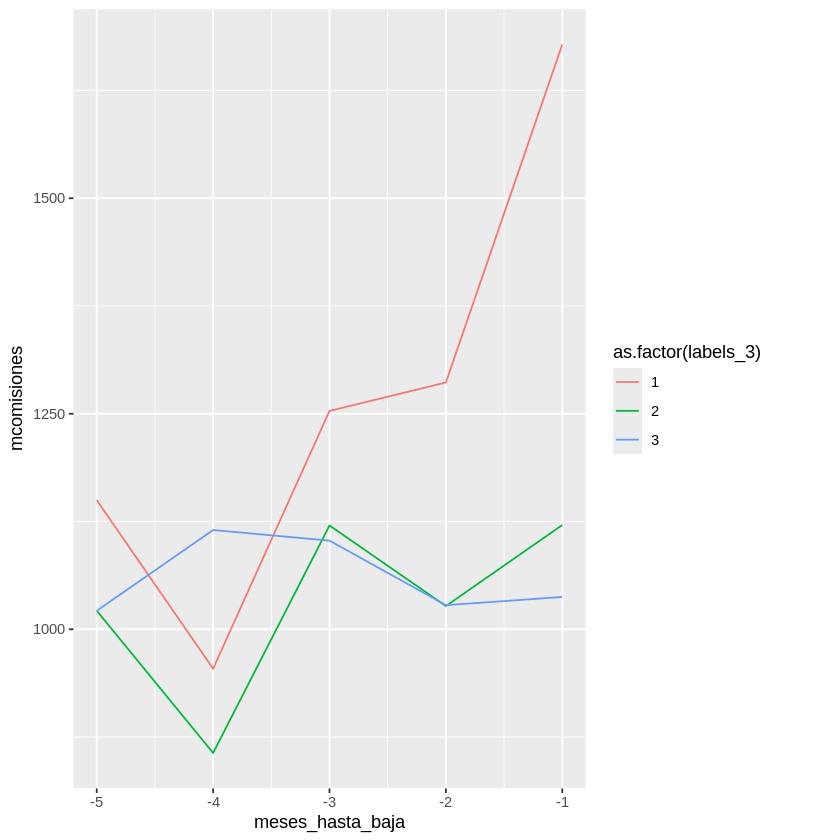

In [37]:
if(!require("ggplot2")) install.packages("ggplot2")
require("ggplot2")


# graficamos una variable cualquiera del dataset y lo agrupamos por los clusters, tomando la media de esta variable al graficar
# en caso de que esta visualización no los convenza (y con razón) recomendamos explorar la función geom_smooth() para que genere
# líneas suavizadas y con los errores estándar de cada promedio
ggplot(data=dataset_historico[,list(mcomisiones=mean(mcomisiones)),by=list(meses_hasta_baja,labels_3)])+
  aes(x=meses_hasta_baja,y=mcomisiones,group=labels_3,color=as.factor(labels_3))+
  geom_line()